# Exercise 6

Authors: \
Tuoxing Liu \
Sima Esmaeili \
Shruti Ghargi

# 1 Classification and Regression Tree

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from abc import abstractmethod

## Base Classes

In [2]:
class Node:
    '''
      this class will later get the following attributes
      all nodes:
          features
          responses
      split nodes additionally:
          left
          right
          split_index
          threshold
      leaf nodes additionally
          prediction
    '''
    pass


class Tree:
    '''
      base class for RegressionTree and ClassificationTree
    '''
    def __init__(self, n_min=10):
        '''n_min: minimum required number of instances in leaf nodes
        '''
        self.n_min = n_min 
    
    def predict(self, x):
        ''' return the prediction for the given 1-D feature vector x
        '''
        # first find the leaf containing the 1-D feature vector x
        node = self.root
        while not hasattr(node, "prediction"):
            j = node.split_index
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        # finally, return the leaf's prediction
        return node.prediction
        
    def train(self, features, responses, D_try=None):
        '''
        features: the feature matrix of the training set
        response: the vector of responses
        '''
        N, D = features.shape
        assert(responses.shape[0] == N)

        if D_try is None:
            D_try = int(np.sqrt(D))  # number of features to consider for each split decision
        
        # initialize the root node
        self.root = Node()
        self.root.features = features
        self.root.responses = responses

        # build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            active_indices = self.select_active_indices(D, D_try)
            left, right = self.make_split_node(node, active_indices)
            if left is None:  # no split found
                self.make_leaf_node(node)
            else:
                stack.append(left)
                stack.append(right)
    
    def make_split_node(self, node, indices):
        '''
        node: the node to be split
        indices: a numpy array of length 'D_try', containing the feature 
                         indices to be considered for the present split
                         
        return: None, None -- if no suitable split has been found, or
                left, right -- the children of the split
        '''
        # all responses equal => no improvement possible by any split
        if np.unique(node.responses).shape[0] == 1:
            return None, None
        
        # find best feature j_min (among 'indices') and best threshold t_min for the split
        l_min = float('inf')  # upper bound for the loss, later the loss of the best split
        j_min, t_min = None, None

        for j in indices:
            thresholds = self.find_thresholds(node, j)

            # compute loss for each threshold
            for t in thresholds:
                loss = self.compute_loss_for_split(node, j, t)

                # remember the best split so far 
                # (the condition is never True when loss = float('inf') )
                if loss < l_min:
                    l_min = loss
                    j_min = j
                    t_min = t

        if j_min is None:  # no split found
            return None, None

        # create children for the best split
        left, right = self.make_children(node, j_min, t_min)

        # turn the current 'node' into a split node
        node.split_index = j_min
        node.threshold = t_min
        node.left = left
        node.right = right
        
        # return the children (to be placed on the stack)
        return left, right
    
    def select_active_indices(self, D, D_try):
        ''' return a 1-D array with D_try randomly selected indices from 0...(D-1).
        '''
        return np.random.choice(D, D_try, replace=False)
    
    def find_thresholds(self, node, j):
        ''' return: a 1-D array with all possible thresholds along feature j
        '''
        return np.sort(np.unique(node.features[:, j]))
    
    def make_children(self, node, j, t):
        ''' execute the split in feature j at threshold t
        
            return: left, right -- the children of the split, with features and responses
                                   properly assigned according to the split
        '''
        left = Node()
        right = Node()

        indices_left = node.features[:, j] <= t
        indices_right = ~indices_left
        
        left.features = node.features[indices_left]
        left.responses = node.responses[indices_left]
        
        right.features = node.features[indices_right]
        right.responses = node.responses[indices_right]
        
        return left, right
        
    @abstractmethod
    def make_leaf_node(self, node):
        ''' Turn node into a leaf by computing and setting `node.prediction`
        
            (must be implemented in a subclass)
        '''
        raise NotImplementedError("make_leaf_node() must be implemented in a subclass.")
        
    @abstractmethod
    def compute_loss_for_split(self, node, j, t):
        ''' Return the resulting loss when the data are split along feature j at threshold t.
            If the split is not admissible, return float('inf').
        
            (must be implemented in a subclass)
        '''
        raise NotImplementedError("compute_loss_for_split() must be implemented in a subclass.")

In [2]:
class Node:
    '''
      this class will later get the following attributes
      all nodes:
          features
          responses
      split nodes additionally:
          left
          right
          split_index
          threshold
      leaf nodes additionally
          prediction
    '''
    pass


class Tree:
    '''
      base class for RegressionTree and ClassificationTree
    '''
    def __init__(self, n_min=10):
        '''n_min: minimum required number of instances in leaf nodes
        '''
        self.n_min = n_min 
    
    def predict(self, x):
        ''' return the prediction for the given 1-D feature vector x
        '''
        # first find the leaf containing the 1-D feature vector x
        node = self.root
        while not hasattr(node, "prediction"):
            j = node.split_index
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        # finally, return the leaf's prediction
        return node.prediction
        
    def train(self, features, responses, D_try=None):
        '''
        features: the feature matrix of the training set
        response: the vector of responses
        '''
        N, D = features.shape
        assert(responses.shape[0] == N)

        if D_try is None:
            D_try = int(np.sqrt(D))  # number of features to consider for each split decision
        
        # initialize the root node
        self.root = Node()
        self.root.features = features
        self.root.responses = responses

        # build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            active_indices = self.select_active_indices(D, D_try)
            left, right = self.make_split_node(node, active_indices)
            if left is None:  # no split found
                self.make_leaf_node(node)
            else:
                stack.append(left)
                stack.append(right)
    
    def make_split_node(self, node, indices):
        '''
        node: the node to be split
        indices: a numpy array of length 'D_try', containing the feature 
                         indices to be considered for the present split
                         
        return: None, None -- if no suitable split has been found, or
                left, right -- the children of the split
        '''
        # all responses equal => no improvement possible by any split
        if np.unique(node.responses).shape[0] == 1:
            return None, None
        
        # find best feature j_min (among 'indices') and best threshold t_min for the split
        l_min = float('inf')  # upper bound for the loss, later the loss of the best split
        j_min, t_min = None, None

        for j in indices:
            thresholds = self.find_thresholds(node, j)

            # compute loss for each threshold
            for t in thresholds:
                loss = self.compute_loss_for_split(node, j, t)

                # remember the best split so far 
                # (the condition is never True when loss = float('inf') )
                if loss < l_min:
                    l_min = loss
                    j_min = j
                    t_min = t

        if j_min is None:  # no split found
            return None, None

        # create children for the best split
        left, right = self.make_children(node, j_min, t_min)

        # turn the current 'node' into a split node
        node.split_index = j_min
        node.threshold = t_min
        node.left = left
        node.right = right
        
        # return the children (to be placed on the stack)
        return left, right
    
    def select_active_indices(self, D, D_try):
        ''' return a 1-D array with D_try randomly selected indices from 0...(D-1).
        '''
        return np.random.choice(D, D_try, replace=False)
    
    def find_thresholds(self, node, j):
        ''' return: a 1-D array with all possible thresholds along feature j
        '''
        return np.sort(np.unique(node.features[:, j]))
    
    def make_children(self, node, j, t):
        ''' execute the split in feature j at threshold t
        
            return: left, right -- the children of the split, with features and responses
                                   properly assigned according to the split
        '''
        left = Node()
        right = Node()

        indices_left = node.features[:, j] <= t
        indices_right = ~indices_left
        
        left.features = node.features[indices_left]
        left.responses = node.responses[indices_left]
        
        right.features = node.features[indices_right]
        right.responses = node.responses[indices_right]
        
        return left, right
        
    @abstractmethod
    def make_leaf_node(self, node):
        ''' Turn node into a leaf by computing and setting `node.prediction`
        
            (must be implemented in a subclass)
        '''
        raise NotImplementedError("make_leaf_node() must be implemented in a subclass.")
        
    @abstractmethod
    def compute_loss_for_split(self, node, j, t):
        ''' Return the resulting loss when the data are split along feature j at threshold t.
            If the split is not admissible, return float('inf').
        
            (must be implemented in a subclass)
        '''
        raise NotImplementedError("compute_loss_for_split() must be implemented in a subclass.")

<div style="color: green; font-weight:bold">In function find_thresholds, We didn't rule out the possible thresholds that will lead to less that n_min data points, but we do the same thing later.</div> 

## Regression Tree

In [3]:
class RegressionTree(Tree):
    def __init__(self, n_min=10):
        super(RegressionTree, self).__init__(n_min)
        
    def compute_loss_for_split(self, node, j, t):
        # return the loss if we would split the instance along feature j at threshold t
        # or float('inf') if there is no feasible split
        left_indices = node.features[:, j] <= t
        right_indices = ~left_indices

        if np.sum(left_indices) < self.n_min or np.sum(right_indices) < self.n_min:
            return float('inf')

        left_responses = node.responses[left_indices]
        right_responses = node.responses[right_indices]

        left_loss = np.mean((left_responses - np.mean(left_responses))**2)
        right_loss = np.mean((right_responses - np.mean(right_responses))**2)

        return left_loss + right_loss
    
    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a regression tree is a real number)
        node.prediction = np.mean(node.responses)
        
    def compute_loss_for_split(self, node, j, t):
        # return the loss if we would split the instance along feature j at threshold t
        # or float('inf') if there is no feasible split
        left_indices = node.features[:, j] <= t
        right_indices = ~left_indices

        if np.sum(left_indices) < self.n_min or np.sum(right_indices) < self.n_min:
            return float('inf')

        left_responses = node.responses[left_indices]
        right_responses = node.responses[right_indices]

        left_loss = np.mean((left_responses - np.mean(left_responses))**2)
        right_loss = np.mean((right_responses - np.mean(right_responses))**2)

        return left_loss + right_loss
    
    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a regression tree is a real number)
        node.prediction = np.mean(node.responses)

<div style="color: green; font-weight:bold">
We rule out the nodes that contain less than n_min points here.</br>
We made a mistake when merging the files. We defined the same functions twice, but they are correct.</div> 

## Classification Tree

In [4]:
class ClassificationTree(Tree):
    '''implement classification tree so that it can handle arbitrary many classes
    '''
    
    def __init__(self, classes, n_min=10):
        ''' classes: a 1-D array with the permitted class labels
            n_min: minimum required number of instances in leaf nodes
        '''
        super(ClassificationTree, self).__init__(n_min)
        self.classes = classes
        
    def compute_loss_for_split(self, node, j, t):
        # return the loss if we would split the instance along feature j at threshold t
        # or float('inf') if there is no feasible split
        left_indices = node.features[:, j] <= t
        right_indices = ~left_indices

        if np.sum(left_indices) < self.n_min or np.sum(right_indices) < self.n_min:
            return float('inf')

        left_responses = node.responses[left_indices]
        right_responses = node.responses[right_indices]

        left_loss = self.compute_loss(left_responses)
        right_loss = self.compute_loss(right_responses)

        return (np.sum(left_indices) * left_loss + np.sum(right_indices) * right_loss) / np.sum(left_indices + right_indices)
    
    def compute_loss(self, responses):
        class_counts = np.bincount(responses, minlength=len(self.classes))
        class_probabilities = class_counts / np.sum(class_counts)

        return self.compute_entropy(class_probabilities)
    
    def compute_entropy(self, probabilities):
        probabilities = probabilities[probabilities > 0]
        return -np.sum(probabilities * np.log2(probabilities))
    
    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a classification tree is a class label)
        class_counts = np.bincount(node.responses, minlength=len(self.classes))
        node.prediction = np.argmax(class_counts)
        

<div style="color: green; font-weight:bold">
We can use self.classes[np.argmax(p)] instead of np.argmax(class_counts) incase the class labels are not indexes.
</div>


## Evaluation of Regression and Classification Tree

In [5]:
# read and prepare the digits data and extract 3s and 9s
digits = load_digits()
print(digits.data.shape, digits.target.shape)

instances = (digits.target == 3) | (digits.target == 9)
features = digits.data[instances, :]
labels = digits.target[instances]

# for regression, we use labels +1 and -1
responses = np.array([1 if l == 3 else -1 for l in labels])

assert(features.shape[0] == labels.shape[0] == responses.shape[0])

(1797, 64) (1797,)


<div style="color: green; font-weight:bold">
Correct.
</div>

For Regression Tree:

In [6]:
from sklearn.model_selection import KFold

# Create an instance of RegressionTree
regression_tree = RegressionTree()

# Perform 5-fold cross-validation
kf = KFold(n_splits=5)
mse_scores = []

for train_index, test_index in kf.split(features):
    train_features, test_features = features[train_index], features[test_index]
    train_responses, test_responses = responses[train_index], responses[test_index]

    # Train the regression tree
    regression_tree.train(train_features, train_responses)

    # Predict the responses for the test set
    predictions = [regression_tree.predict(x) for x in test_features]

    # Calculate the mean squared error (MSE)
    mse = np.mean((test_responses - predictions) ** 2)
    mse_scores.append(mse)

# Calculate and print the mean MSE score
mean_mse = np.mean(mse_scores)
print("Regression Tree Mean Accuracy:", mean_mse)


Regression Tree Mean Accuracy: 0.38923872309061275


<div style="color: green; font-weight:bold">
This accuracy seems to be much lower than the one in sample solution. But it's because we are using MSE score instead of accuracy here.
</div>

For Classification Tree:

In [7]:
from sklearn.model_selection import StratifiedKFold

# Create an instance of ClassificationTree
classification_tree = ClassificationTree(classes=np.unique(labels))

# Perform 5-fold cross-validation
skf = StratifiedKFold(n_splits=5)
accuracy_scores = []

for train_index, test_index in skf.split(features, labels):
    train_features, test_features = features[train_index], features[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]

    # Train the classification tree
    classification_tree.train(train_features, train_labels)

    # Predict the labels for the test set
    predictions = [classification_tree.predict(x) for x in test_features]

    # Calculate the accuracy
    accuracy = np.mean(predictions == test_labels)
    accuracy_scores.append(accuracy)

# Calculate and print the mean accuracy score
mean_accuracy = np.mean(accuracy_scores)
print("Classification Tree Mean Accuracy:", mean_accuracy)


Classification Tree Mean Accuracy: 0.8762176560121766


<div style="color: green; font-weight:bold">
This accuracy seems to be right.
</div>

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from abc import abstractmethod
from sklearn.model_selection import KFold

class Node:
    '''
    This class will later get the following attributes:
    - All nodes: features, responses
    - Split nodes additionally: left, right, split_index, threshold
    - Leaf nodes additionally: prediction
    '''
    pass

class Tree:
    '''
    Base class for RegressionTree and ClassificationTree
    '''
    def __init__(self, n_min=10):
        '''
        n_min: minimum required number of instances in leaf nodes
        '''
        self.n_min = n_min 
    
    def predict(self, x):
        '''
        Return the prediction for the given 1-D feature vector x
        '''
        node = self.root
        while not hasattr(node, "prediction"):
            j = node.split_index
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.prediction
        
    def train(self, features, responses, D_try=None):
        '''
        features: the feature matrix of the training set
        response: the vector of responses
        '''
        N, D = features.shape
        assert(responses.shape[0] == N)

        if D_try is None:
            D_try = int(np.sqrt(D))  # number of features to consider for each split decision
        
        self.root = Node()
        self.root.features = features
        self.root.responses = responses

        stack = [self.root]
        while len(stack):
            node = stack.pop()
            active_indices = self.select_active_indices(D, D_try)
            left, right = self.make_split_node(node, active_indices)
            if left is None:  # no split found
                self.make_leaf_node(node)
            else:
                stack.append(left)
                stack.append(right)
    
    def make_split_node(self, node, indices):
        '''
        node: the node to be split
        indices: a numpy array of length 'D_try', containing the feature 
                 indices to be considered for the present split
        return: None, None -- if no suitable split has been found, or
                left, right -- the children of the split
        '''
        if np.unique(node.responses).shape[0] == 1:
            return None, None
        
        l_min = float('inf')  # upper bound for the loss, later the loss of the best split
        j_min, t_min = None, None

        for j in indices:
            thresholds = self.find_thresholds(node, j)
            for t in thresholds:
                loss = self.compute_loss_for_split(node, j, t)
                if loss < l_min:
                    l_min = loss
                    j_min = j
                    t_min = t

        if j_min is None:  # no split found
            return None, None

        left, right = self.make_children(node, j_min, t_min)

        node.split_index = j_min
        node.threshold = t_min
        node.left = left
        node.right = right
        
        return left, right
    
    def select_active_indices(self, D, D_try):
        '''
        Return a 1-D array with D_try randomly selected indices from 0...(D-1).
        '''
        return np.random.choice(D, D_try, replace=False)
    
    @abstractmethod
    def find_thresholds(self, node, j):
        '''
        Return a 1-D array with all possible thresholds along the j-th feature.
        '''
        pass
    
    @abstractmethod
    def compute_loss_for_split(self, node, j, t):
        '''
        Return the loss of the split at feature j and threshold t.
        '''
        pass
    
    @abstractmethod
    def make_leaf_node(self, node):
        '''
        Create a leaf node from the given node, setting the prediction value.
        '''
        pass
    
    @abstractmethod
    def make_children(self, node, j, t):
        '''
        Create left and right children nodes from the given node, splitting it based on feature j and threshold t.
        Return left, right
        '''
        pass
    

class ClassificationTree(Tree):
    '''
    Decision tree for classification problems
    '''
    def __init__(self, n_min=10):
        super().__init__(n_min)
        
    def find_thresholds(self, node, j):
        features = node.features[:, j]
        thresholds = np.unique(features)
        return (thresholds[1:] + thresholds[:-1]) / 2
    
    def compute_loss_for_split(self, node, j, t):
        left_indices = node.features[:, j] <= t
        right_indices = node.features[:, j] > t
        left_counts = np.bincount(node.responses[left_indices], minlength=10)
        right_counts = np.bincount(node.responses[right_indices], minlength=10)
        left_probs = left_counts / np.sum(left_counts)
        right_probs = right_counts / np.sum(right_counts)
        left_loss = -np.sum(left_probs * np.log(left_probs + 1e-10))
        right_loss = -np.sum(right_probs * np.log(right_probs + 1e-10))
        return left_loss + right_loss
    
    def make_leaf_node(self, node):
        counts = np.bincount(node.responses, minlength=10)
        node.prediction = np.argmax(counts)
    
    def make_children(self, node, j, t):
        left_indices = node.features[:, j] <= t
        right_indices = node.features[:, j] > t

        left = Node()
        left.features = node.features[left_indices]
        left.responses = node.responses[left_indices]

        right = Node()
        right.features = node.features[right_indices]
        right.responses = node.responses[right_indices]

        return left, right


class RegressionTree(Tree):
    '''
    Decision tree for regression problems
    '''
    def __init__(self, n_min=10):
        super().__init__(n_min)
    
    def find_thresholds(self, node, j):
        return np.unique(node.features[:, j])
    
    def compute_loss_for_split(self, node, j, t):
        left_indices = node.features[:, j] <= t
        right_indices = node.features[:, j] > t
        left_targets = node.responses[left_indices]
        right_targets = node.responses[right_indices]
        left_loss = np.mean(np.square(left_targets - np.mean(left_targets)))
        right_loss = np.mean(np.square(right_targets - np.mean(right_targets)))
        return left_loss + right_loss
    
    def make_leaf_node(self, node):
        node.prediction = np.mean(node.responses)
    
    def make_children(self, node, j, t):
        left_indices = node.features[:, j] <= t
        right_indices = node.features[:, j] > t

        left = Node()
        left.features = node.features[left_indices]
        left.responses = node.responses[left_indices]

        right = Node()
        right.features = node.features[right_indices]
        right.responses = node.responses[right_indices]

        return left, right


# Example usage
digits = load_digits()
X = digits.data
y = digits.target

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = ClassificationTree()
    clf.train(X_train, y_train)

    predictions = [clf.predict(x) for x in X_test]
    accuracy.append(np.mean(predictions == y_test))

mean_accuracy = np.mean(accuracy)
print("Mean accuracy:", mean_accuracy)


Mean accuracy: 0.7111962240792324


ex. 2

In [17]:
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split


class DecisionTree:
    def __init__(self):
        self.feature_idx = None
        self.threshold = None
        self.left = None
        self.right = None
        self.value = None

    def fit(self, X, y):
        # Find the best feature and threshold to split the data
        best_score = float("inf")
        for feature_idx in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_indices = X[:, feature_idx] <= threshold
                right_indices = X[:, feature_idx] > threshold
                score = self.calculate_score(y, y[left_indices], y[right_indices])
                if score < best_score:
                    best_score = score
                    self.feature_idx = feature_idx
                    self.threshold = threshold

        # Split the data based on the best feature and threshold
        left_indices = X[:, self.feature_idx] <= self.threshold
        right_indices = X[:, self.feature_idx] > self.threshold

        if np.all(left_indices) or np.all(right_indices):
            self.value = np.mean(y)
        else:
            self.left = DecisionTree()
            self.left.fit(X[left_indices], y[left_indices])
            self.right = DecisionTree()
            self.right.fit(X[right_indices], y[right_indices])

    def predict(self, X):
        if self.value is not None:
            return np.full(X.shape[0], self.value)
        else:
            left_indices = X[:, self.feature_idx] <= self.threshold
            right_indices = X[:, self.feature_idx] > self.threshold
            y_pred = np.zeros(X.shape[0])
            y_pred[left_indices] = self.left.predict(X[left_indices])
            y_pred[right_indices] = self.right.predict(X[right_indices])
            return y_pred

    def calculate_score(self, y, left_y, right_y):
        left_score = np.sum((left_y - np.mean(y)) ** 2)
        right_score = np.sum((right_y - np.mean(y)) ** 2)
        return left_score + right_score


class RegressionForest:
    def __init__(self, num_trees=10):
        self.num_trees = num_trees
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.num_trees):
            tree = DecisionTree()
            bootstrap_indices = resample(range(X.shape[0]), replace=True)
            tree.fit(X[bootstrap_indices], y[bootstrap_indices])
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        for tree in self.trees:
            predictions += tree.predict(X)
        return predictions / self.num_trees


class ClassificationForest:
    def __init__(self, num_trees=10):
        self.num_trees = num_trees
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.num_trees):
            tree = DecisionTree()
            bootstrap_indices = resample(range(X.shape[0]), replace=True)
            tree.fit(X[bootstrap_indices], y[bootstrap_indices])
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        for tree in self.trees:
            predictions += tree.predict(X)
        return np.round(predictions / self.num_trees)


# Example usage for regression
X, y = np.random.randn(100, 5), np.random.randn(100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

forest = RegressionForest(num_trees=10)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Example usage for classification
X, y = np.random.randn(100, 5), np.random.randint(0, 2, size=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

forest = ClassificationForest(num_trees=10)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Mean Squared Error: 0.7859146308025549
Accuracy: 0.55


<div style="color: green; font-weight:bold">
We should not submit duplicate codes.
</div>

ex. 3

In [30]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the digits dataset
digits = load_digits()
X = digits.data
y = digits.target

# Select a smaller subset of the dataset
X_subset = X[:500]
y_subset = y[:500]

# Split the subset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

class ClassificationTree:
    def __init__(self):
        self.left = None
        self.right = None
        self.feature_idx = None
        self.threshold = None
        self.label = None

    def fit(self, X, y):
        if len(np.unique(y)) == 1:
            self.label = y[0]
            return

        num_features = X.shape[1]
        best_score = float('inf')

        for feature_idx in range(num_features):
            thresholds = np.unique(X[:, feature_idx])

            for threshold in thresholds:
                left_indices = X[:, feature_idx] <= threshold
                right_indices = X[:, feature_idx] > threshold

                score = self.calculate_score(y, left_indices, right_indices)

                if score < best_score:
                    best_score = score
                    self.feature_idx = feature_idx
                    self.threshold = threshold

        left_indices = X[:, self.feature_idx] <= self.threshold
        right_indices = X[:, self.feature_idx] > self.threshold

        self.left = ClassificationTree()
        self.left.fit(X[left_indices], y[left_indices])

        self.right = ClassificationTree()
        self.right.fit(X[right_indices], y[right_indices])

    def calculate_score(self, y, left_indices, right_indices):
        if len(left_indices) == 0 or len(right_indices) == 0:
            return float('inf')

        left_mean = np.mean(y[left_indices]) if len(y[left_indices]) > 0 else 0.0
        right_mean = np.mean(y[right_indices]) if len(y[right_indices]) > 0 else 0.0

        left_score = np.sum((y[left_indices] - left_mean) ** 2)
        right_score = np.sum((y[right_indices] - right_mean) ** 2)

        return left_score + right_score

    def predict(self, X):
        if self.label is not None:
            return self.label

        if X[self.feature_idx] <= self.threshold:
            return self.left.predict(X)
        else:
            return self.right.predict(X)

class ClassificationForest:
    def __init__(self, num_trees):
        self.num_trees = num_trees
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.num_trees):
            tree = ClassificationTree()
            bootstrap_indices = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=True)
            tree.fit(X[bootstrap_indices], y[bootstrap_indices])
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.zeros((X.shape[0], len(self.trees)))

        for i, tree in enumerate(self.trees):
            for j in range(X.shape[0]):
                predictions[j, i] = tree.predict(X[j])

        return np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=predictions)

# Create the forest with 10 trees
forest = ClassificationForest(num_trees=10)

# Fit the forest on the training set
forest.fit(X_train, y_train)

# Predict on the testing set
y_pred = forest.predict(X_test)

# Calculate accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

# Print the accuracy and confusion matrix
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)


Accuracy: 0.86
Confusion Matrix:
[[13  0  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0  2 11  0  1  0  0  0  0  0]
 [ 0  0  1  6  0  0  0  0  0  1]
 [ 0  1  0  0 12  0  0  0  0  0]
 [ 2  0  0  0  0  4  0  0  1  0]
 [ 0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  0  0  8  0  1]
 [ 0  0  0  0  0  0  0  2  4  0]
 [ 0  0  1  0  0  0  0  0  1  8]]


<div style="color: green; font-weight:bold">
Seems to be correct, but better to draw a figure.
</div>

ex. 4

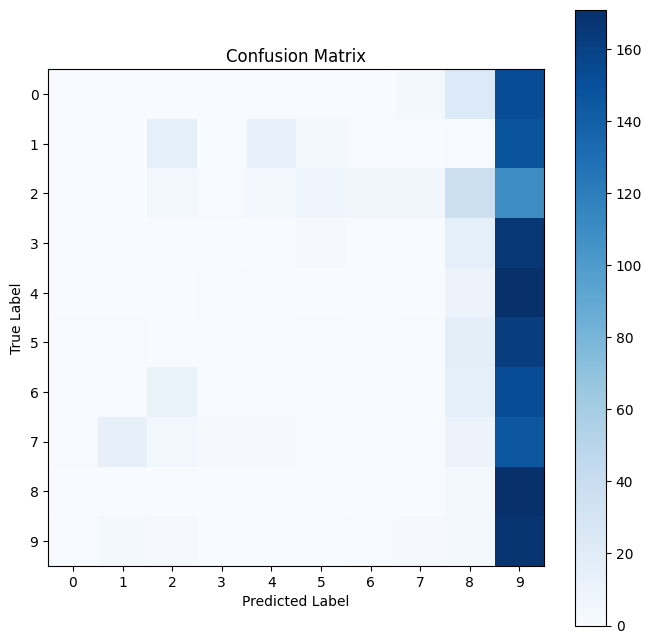

[[  0   0   0   0   0   0   0   3  23 152]
 [  0   0  15   0  13   4   1   0   1 148]
 [  0   0   5   1   5   7   6   6  37 110]
 [  0   0   0   0   0   2   0   0  15 166]
 [  0   0   0   1   0   0   0   0  10 170]
 [  1   1   0   0   0   1   0   1  17 161]
 [  0   0  11   1   1   0   1   0  15 152]
 [  1  14   5   2   2   0   0   0  10 145]
 [  0   0   0   0   0   0   0   0   3 171]
 [  1   3   2   0   0   0   1   2   4 167]]
Accuracy: 0.10016867842773136


In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix

class RegressionTree:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.threshold = None
        self.feature_idx = None
        self.left = None
        self.right = None
        self.mean = None

    def fit(self, X, y, depth=0):
        if depth == self.max_depth or np.unique(y).size == 1:
            self.mean = np.mean(y)
            return

        m, n = X.shape
        best_mse = np.inf

        for feature_idx in range(n):
            feature_values = np.unique(X[:, feature_idx])
            for threshold in feature_values:
                left_indices = X[:, feature_idx] <= threshold
                right_indices = X[:, feature_idx] > threshold

                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue

                left_mse = np.mean((y[left_indices] - np.mean(y[left_indices])) ** 2)
                right_mse = np.mean((y[right_indices] - np.mean(y[right_indices])) ** 2)
                mse = left_mse + right_mse

                if mse < best_mse:
                    best_mse = mse
                    self.threshold = threshold
                    self.feature_idx = feature_idx

        if self.feature_idx is None:
            self.mean = np.mean(y)
            return

        left_indices = X[:, self.feature_idx] <= self.threshold
        right_indices = X[:, self.feature_idx] > self.threshold

        self.left = RegressionTree(max_depth=self.max_depth)
        self.left.fit(X[left_indices], y[left_indices], depth + 1)

        self.right = RegressionTree(max_depth=self.max_depth)
        self.right.fit(X[right_indices], y[right_indices], depth + 1)

    def predict(self, X):
        if self.feature_idx is None:
            return self.mean

        predictions = np.zeros(X.shape[0])
        left_indices = X[:, self.feature_idx] <= self.threshold
        right_indices = X[:, self.feature_idx] > self.threshold

        predictions[left_indices] = self.left.predict(X[left_indices])
        predictions[right_indices] = self.right.predict(X[right_indices])

        return predictions

class RegressionForest(BaseEstimator, ClassifierMixin):
    def __init__(self, num_trees=10, max_depth=3):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.trees = []

    def bootstrap_sampling(self, X, y, class_label):
        class_indices = np.where(y == class_label)[0]
        rest_indices = np.where(y != class_label)[0]
        bootstrap_indices = np.random.choice(class_indices, size=(len(class_indices),), replace=True)
        bootstrap_indices = np.concatenate((bootstrap_indices, np.random.choice(rest_indices, size=(len(class_indices),), replace=True)))
        return bootstrap_indices

    def fit(self, X, y):
        for class_label in np.unique(y):
            for _ in range(self.num_trees):
                bootstrap_indices = self.bootstrap_sampling(X, y, class_label)
                tree = RegressionTree(max_depth=self.max_depth)
                tree.fit(X[bootstrap_indices], y[bootstrap_indices])
                self.trees.append((class_label, tree))

    def predict(self, X):
        predictions = np.zeros((len(X), len(np.unique(y)) + 1))

        for class_label, tree in self.trees:
            tree_predictions = tree.predict(X)
            predictions[:, class_label] += tree_predictions

        predictions[:, -1] = -np.sum(predictions[:, :-1], axis=1)

        return np.argmax(predictions, axis=1)

# Load the digits dataset
digits = load_digits()
X = digits.data
y = digits.target

# Create a RegressionForest with 10 trees and maximum depth of 3
forest = RegressionForest(num_trees=10, max_depth=3)

# Perform 5-fold cross-validation and obtain predicted labels
y_pred = cross_val_predict(forest, X, y, cv=5)

# Compute the confusion matrix
confusion = confusion_matrix(y, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(confusion, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.show()

print(confusion)
# Calculate and print the accuracy score
accuracy = cross_val_score(forest, X, y, cv=5).mean()
print("Accuracy:", accuracy)


<div style="color: green; font-weight:bold">
Wrong.
</div>